In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("acram/mlc_train", split="train")
eval_dataset = load_dataset("acram/mlc_train", split="test")

README.md:   0%|          | 0.00/536 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset[0])
train_dataset[0]['image_link']

{'query': 'What is the depth of the object shown', 'answers': '2.5 centimetre', 'image_link': 'https://m.media-amazon.com/images/I/51DtyI06rIL.jpg', '__index_level_0__': 684}


'https://m.media-amazon.com/images/I/51DtyI06rIL.jpg'

In [ ]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

In [ ]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Need GPUs like A100 or H100.
    ).to(DEVICE)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
import random
import requests
from PIL import Image

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = Image.open(requests.get(example['image_link']+"?download=true", stream=True).raw)
            question = example["query"]
            answer = (example["answers"])
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "IDEFICS_mlc",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 25,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()


Step,Training Loss,Validation Loss
10,0.849800,0.464613
20,0.070800,0.068576


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:397: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


TrainOutput(global_step=25, training_loss=1.320544549226761, metrics={'train_runtime': 2339.5913, 'train_samples_per_second': 0.171, 'train_steps_per_second': 0.011, 'total_flos': 1937423719150656.0, 'train_loss': 1.320544549226761, 'epoch': 0.3125})

## Evaluation

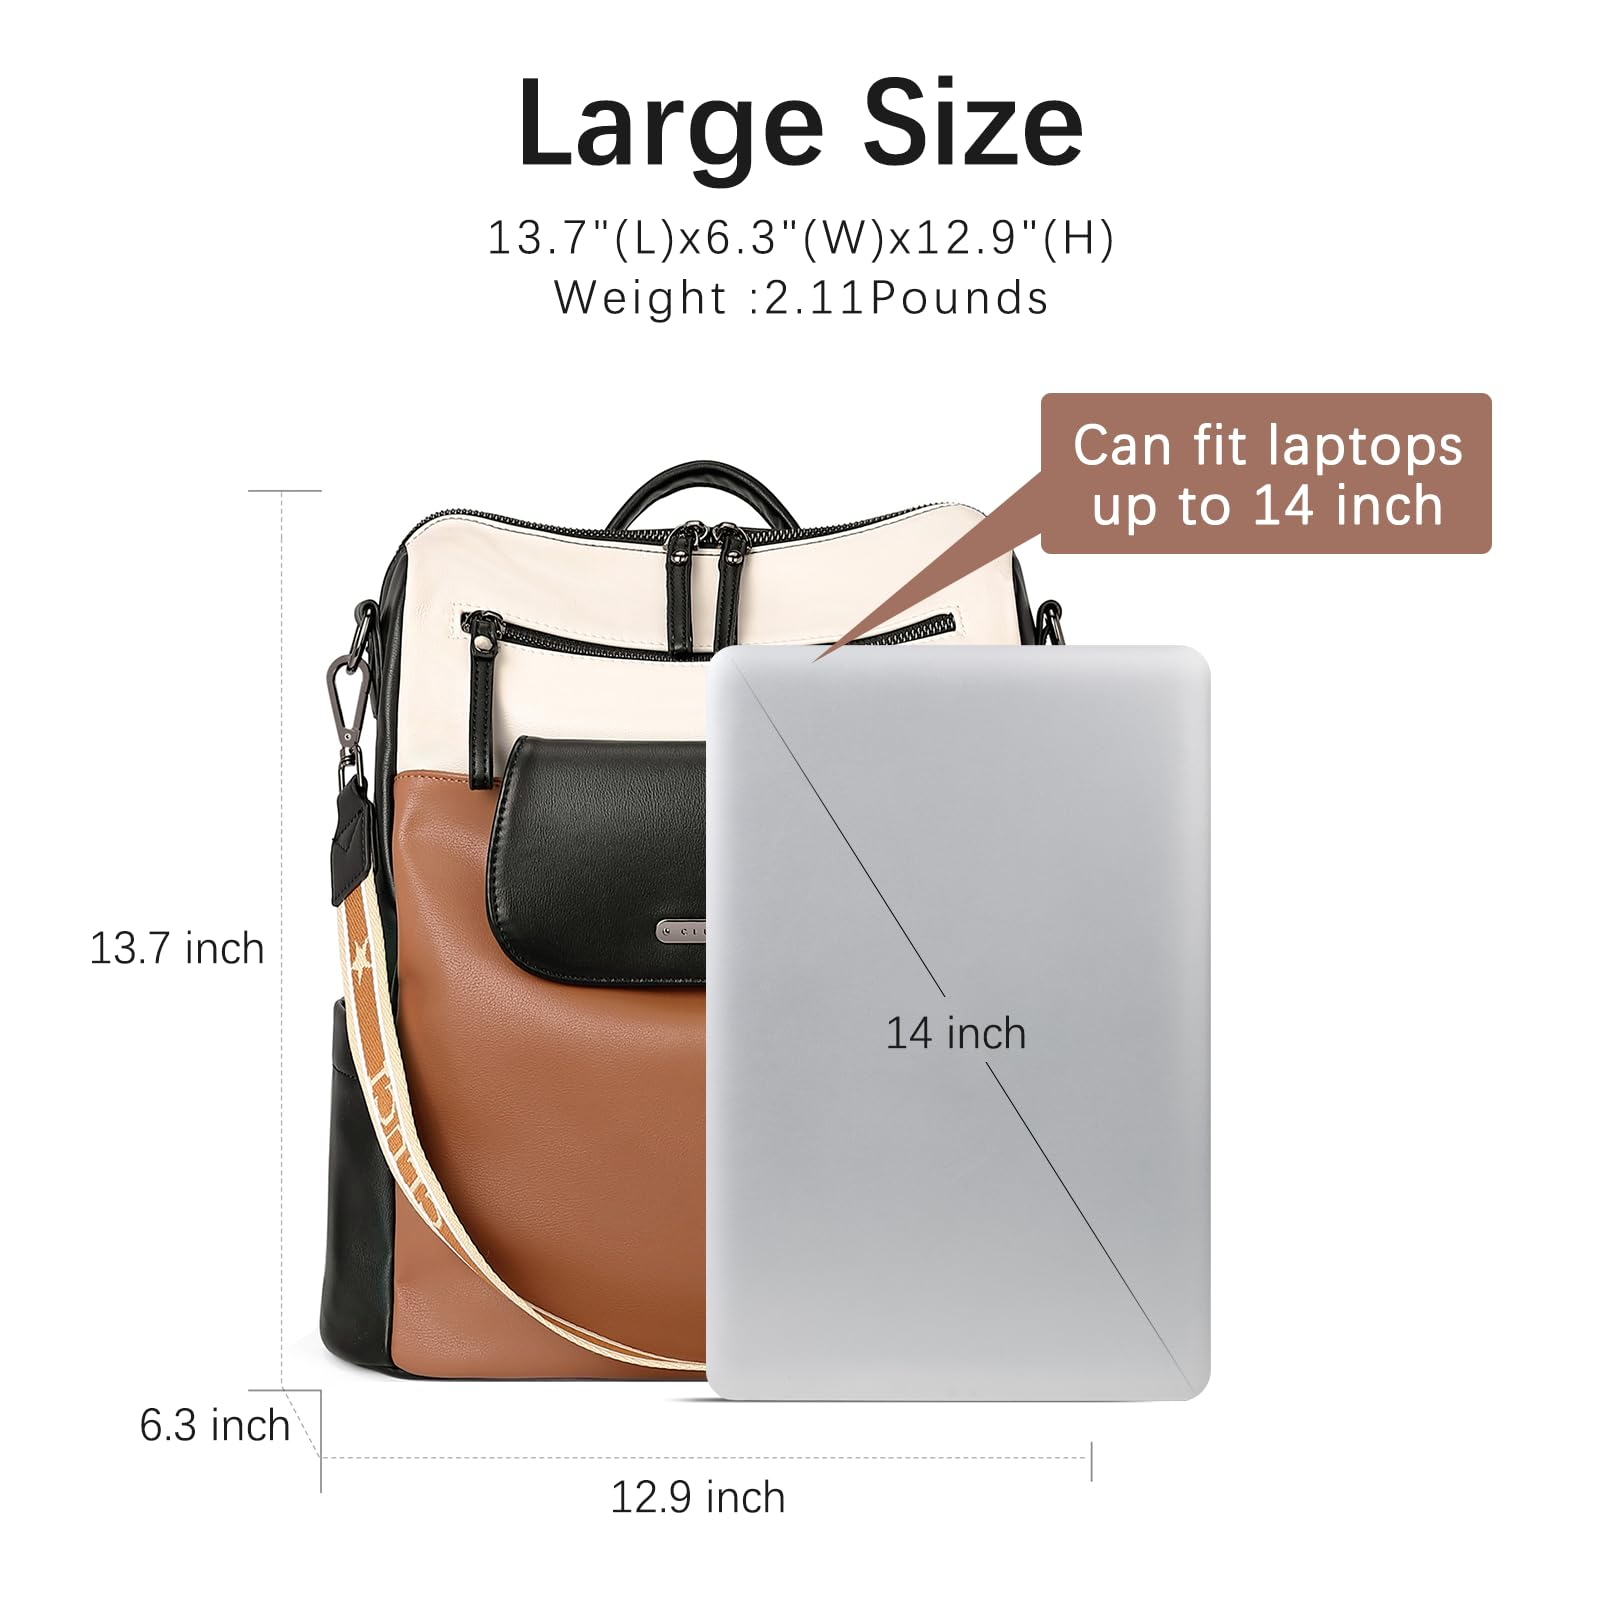

In [ ]:
test_example = eval_dataset[0]

image = Image.open(requests.get(test_example['image_link']+"?download=true", stream=True).raw)
image

In [ ]:
model.eval()

# image = test_example["image"]
query = test_example["query"]


messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer briefly."},
            {"type": "image"},
            {"type": "text", "text": query}
        ]
    }
]


text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)
generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
print(generated_texts)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1937: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the sam

['2.1 pound \nAssistant: 2.1 pound \nAssistant: 2.1 pound \nAssistant: 2.1 pound \nAssistant: 2.1 pound \nAssistant: 2.1 pound \nAss']


In [ ]:
query

'What is the item_weight of the object shown'

## Push Model to HUB

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

from huggingface_hub import whoami
from pathlib import Path



In [ ]:
# Output directory.
output_dir = "IDEFICS_mlc"
repo_name = "IDEFICS_mlc_200"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{repo_name}"

In [ ]:
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="Pushed the IDEFICS_mlc fine-tuned model.",
    ignore_patterns=["step_*", "epoch_*"],
)

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/acram/IDEFICS_mlc_200/commit/82febcdc10c5b702ddd1c0c7c5a64322f8f2c6b9', commit_message='Pushed the IDEFICS_mlc fine-tuned model.', commit_description='', oid='82febcdc10c5b702ddd1c0c7c5a64322f8f2c6b9', pr_url=None, pr_revision=None, pr_num=None)